# Resolviendo un problema de regresion
en esta ocasión vamos a resolver un problema de house pricing, para ello vamos a utilizar el dataset de Boston Housing price regression dataset el cual contiene 404 muestras de casas, cada casa contiene 13 variables continuas que expresan atributos de la casa.

Nuestra tarea entonces será predecir el valor de la casa con base en los 13 atributos mencionados anteriormente. La metodología como es costumbre será similar a los ejemplos anteriores, sin embargo; para este específico mini proyecto utilizaremos una estrategia de validación del modelo diferente.

En este ejemplo usaremos k-Fold Cross Validation descrito en la clase anterior. Para ello crearemos una función que contenga el modelo, su arquitectura y compilado y lo correremos para cada uno de los folds de validación.

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers, models
from keras.datasets import boston_housing

# Biblioteca para implementar K-Fold
from sklearn.model_selection import KFold

# Biblioteca para implementar normalizacion de datos numericos 
from sklearn.preprocessing import StandardScaler

Definimos la arquitectura del modelo

In [63]:
def build_model_regression(dim):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=dim))
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())
    # Como la última capa es una predicción de regresión, NO necesita una capa de activación
    model.add(layers.Dense(1))
    # El error sí será el mean squared error, pero la métrica debe ser diferente, en este caso max absolute error
    model.compile(optimizer='rmsprop', loss='mse', metrics='mae')
    return model

Los puntos claves a destacar son:

- La función de perdida es mean squared error (mse)

- Como nuestro problema es una regresión la métrica de éxito es mean absolut error (mae)

- Dado que la última capa del modelo NO es para clasificar, NO es necesario que tenga ninguna función de activación.

- input_dim es una variante de input_shape la cual solo necesita especificar la canatidad de elementos en la entrada.

- de la red.

Cargar datos

In [64]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [65]:
print(train_data[0])
print(train_data.shape)
print(train_targets[0])
print(train_targets.shape)

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
(404, 13)
15.2
(404,)


Podemos conocer el valor de los 13 atributos de la casa y conocer que el precio de la misma es de 15.2 Mil dólares.

## Generando particiones de K-fold

El primer paso es definir el objeto kf de la clase KFoldy pedirle que genere 5 folds

In [66]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Adicionalmente, para que estas particiones sean replicables pondremos su random_state en un valor fijo. Ahora definimos una función auxiliar que nos permita dado unos vectores de valores de datos y de targets regrese las particiones de x_train, x_test, y_train, y_test:

In [67]:
def train_test_split_kf(xs: np.array, ys: np.array, train_size: np.array, test_size: np.array) -> np.array:
    x_train_ = xs[train_size]
    x_test_ = xs[test_size]
    y_train_ = ys[train_size]
    y_test_ = ys[test_size]
    return x_train_, x_test_, y_train_, y_test_

Con la función definida podemos proceder a utilizar los rangos de train y test creados por el objeto kf y de ahí conseguir las particiones esperadas:

In [68]:
all_history = []  # Aquí guardaremos los resultados de cada fold

for n_fold, (train, test) in enumerate(kf.split(train_data)):
    print(f"\t-I'm running fold {n_fold + 1}")
    x_train, x_test, y_train, y_test = train_test_split_kf(xs=train_data, ys=train_targets,
                                                           train_size=train, test_size=test)

	-I'm running fold 1
	-I'm running fold 2
	-I'm running fold 3
	-I'm running fold 4
	-I'm running fold 5


Nota: La función kf.split(vector) toma un vector de entrada y regresa los indices de las particiones para train y test

## Normalizando datos de entrenamiento

Dado que estamos en un problema de regresión es MUY buena idea normalizar los datos, puesto que si tenemos una variable llamada: número de cuartos, quizá el rango de valores pueda ir de (1, 5) sin embargo, si tenemos otra que sea año de construcción cuyos valores esten entre (1930, 2022) podría aparentar que numéricamente hablando es más importante el año de construcción que el número de cuartos.

Para evitar estos inconvenientes lo que se hace es normalizar los datos, para ello a cada muestra del vector se le resta su promedio y se le divide entre su desviación standard. A este tipo de normalizado se le conoce como: StandardScaler Primero: Creamos un objeto de la clase StandarScaler

In [69]:
standard_scaler = StandardScaler()

A este objeto lo vamos a entrenar con la distribución de datos de nuestra partición de entrenamiento x_train:

In [70]:
standard_scaler.fit(x_train)

StandardScaler()

Esto le permite al modelo aprender los valores de mean y std Ahora podemos proceder a normalizar los datos de entrenamiento y validación:

In [71]:
x_train_s = standard_scaler.transform(x_train)
# Es MUY importante tener en cuenta que los datos de prueba NO LOS CONOZCO entonces NO tiene sentido obtener
# el promedio y desviación standard de una muestra que NO conozco por eso estoy normalizando con el promedio
# y std de la muestra a la que mi modelo sí tenía acceso mientras fue entrenada.
x_test_s = standard_scaler.transform(x_test)

## Entrenando el modelo

Ahora podemos construir un modelo que sirva para las particiones de entrenamiento y validación de nuestros fold y ponerlo a entrenar por un número de épocas predefinido:

In [72]:
n_epochs = 40
model = build_model_regression(dim=13)
history = model.fit(x_train_s, y_train, epochs=n_epochs, batch_size=16,
                    validation_data=(x_test_s, y_test), verbose=0)
all_history.append(history.history)

## Análisis de resultados del modelo de regresión

Re estructurando datos de salida

Observemos los resultados de nuestros modelos que fueron guardados en all_history:

In [73]:
out = all_history
out

[{'loss': [551.0299072265625,
   525.0288696289062,
   510.0439758300781,
   489.5654296875,
   466.8522033691406,
   447.4822998046875,
   426.5125427246094,
   399.7454528808594,
   380.1065673828125,
   352.4575500488281,
   332.4391784667969,
   300.1792297363281,
   276.0712585449219,
   256.4076843261719,
   229.25926208496094,
   204.14614868164062,
   179.0965118408203,
   150.87234497070312,
   130.70021057128906,
   109.17914581298828,
   88.88513946533203,
   72.54039001464844,
   61.18064498901367,
   53.004905700683594,
   39.99913787841797,
   39.72078323364258,
   37.822357177734375,
   27.636978149414062,
   32.53810501098633,
   30.416887283325195,
   28.071596145629883,
   26.832115173339844,
   26.09786033630371,
   27.47733497619629,
   25.035484313964844,
   27.548412322998047,
   29.364486694335938,
   29.14887809753418,
   28.218069076538086,
   28.162609100341797],
  'mae': [21.818119049072266,
   21.56244659423828,
   21.285619735717773,
   20.961393356323242,


Esta estructura de diccionarios guardados en una lista NO es tan conveniente, lo que desearemos es un dataframe que contenga el promedio de los 5 folds sobre cada una de las n epochseso lo podemos hacer de la siguiente manera:

In [74]:
def plot_results(out, metric, offset):
    print(out)
    df = {}
    for key in out[0].keys():
        row = []
        for fold in out:
            row.append(fold[key])
        row = np.array(row).mean(axis=0)
        df[key] = row
    frame = pd.DataFrame(df)
    frame = frame[offset:]
    print(frame)
    loss_values = frame['loss']
    val_loss_values = frame['val_loss']
    metric_values = frame[metric]
    val_metric_values = frame[f"val_{metric}"]
    epoch = range(1, len(loss_values) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
    fig.suptitle("Neural Network's Result")
    ax1.set_title("Loss function over epoch")
    ax2.set_title(f"{metric} over epoch")
    ax1.set(ylabel="loss", xlabel="epochs")
    ax2.set(ylabel=metric, xlabel="epochs")
    ax1.plot(epoch, loss_values, 'o-r', label='training')
    ax1.plot(epoch, val_loss_values, '--', label='validation')
    ax2.plot(epoch, metric_values, 'o-r', label='training')
    ax2.plot(epoch, val_metric_values, '--', label='validation')
    ax1.legend()
    ax2.legend()
    plt.show()

## Análisis de resultados final

Finalmente, podemos graficar los resultados de nuestro frame de resultados y observar los resultados de nuestro modelo con nuestra partición de test que hasta este momento NO habíamos utilizado.

[{'loss': [551.0299072265625, 525.0288696289062, 510.0439758300781, 489.5654296875, 466.8522033691406, 447.4822998046875, 426.5125427246094, 399.7454528808594, 380.1065673828125, 352.4575500488281, 332.4391784667969, 300.1792297363281, 276.0712585449219, 256.4076843261719, 229.25926208496094, 204.14614868164062, 179.0965118408203, 150.87234497070312, 130.70021057128906, 109.17914581298828, 88.88513946533203, 72.54039001464844, 61.18064498901367, 53.004905700683594, 39.99913787841797, 39.72078323364258, 37.822357177734375, 27.636978149414062, 32.53810501098633, 30.416887283325195, 28.071596145629883, 26.832115173339844, 26.09786033630371, 27.47733497619629, 25.035484313964844, 27.548412322998047, 29.364486694335938, 29.14887809753418, 28.218069076538086, 28.162609100341797], 'mae': [21.818119049072266, 21.56244659423828, 21.285619735717773, 20.961393356323242, 20.593753814697266, 20.163219451904297, 19.68962287902832, 19.16917610168457, 18.58942222595215, 17.960050582885742, 17.27087211

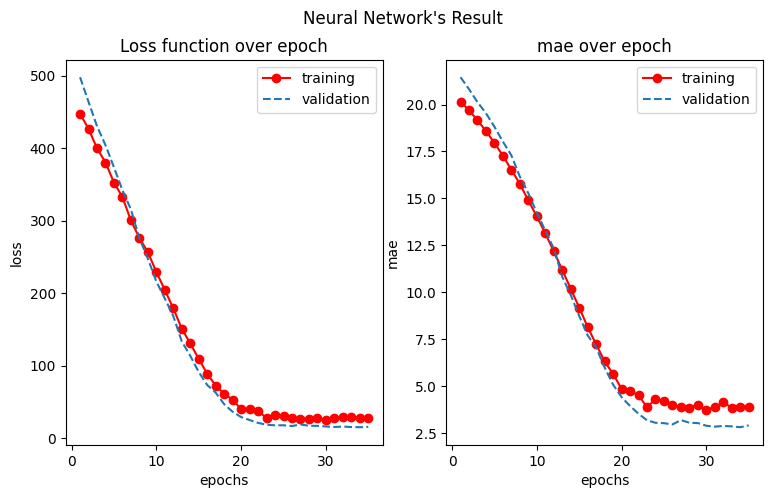

In [75]:
plot_results(out, 'mae', 5)

Finalmente, evaluando la partición de pruebas:

In [76]:
results = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 684031.1875 - mae: 814.0354


ÉXITO TOTAL ÉXITO ROTUNDO Hemos conseguido un error de menos de 1000 dólares en la predicción del precio de una nueva casa.